 # MNIST Classification: Training & Evaluation

In this notebook we show process of train and inference with different models on the MNIST dataset.

## Workflow:
1. Load the dataset
2. Preprocess the data
3. Train classifiers
4. Model Accuracy Comparison
5. Real Predictions on Test Images
6. Edge Cases: Testing Models on Noisy Images
7. Summary

## Import necessary libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from sklearn.metrics import accuracy_score

from data.data_loader import MNISTDataLoader
from data.data_preprocessor import Preprocessor
from models.mnist_classifier import MnistClassifier


## Load Data
- The MNIST dataset consists of 60,000 training images and 10,000 test images of handwritten digits (28x28 pixels).
- We take it from the Tensorflow package.


In [6]:
loader = MNISTDataLoader()

X_train, y_train = loader.get_train_data()
X_test, y_test = loader.get_test_data()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")

Train shape: (60000, 28, 28), Test shape: (10000, 28, 28)
Train labels shape: (60000,), Test labels shape: (10000,)



## Preprocessing
Each model requires a different preprocessing strategy:
- **Random Forest** does not normalize, requires a flat vector.
- **Feed-Forward NN** normalizes and requires a flat vector.
- **CNN** normalizes but keeps the matrix format (28x28x1).


In [16]:
# Define model types and their names
model_types = ["rf", "nn", "cnn"]
model_names = {"rf": "Random Forest", "nn": "FFNN",
               "cnn": "CNN"}

# Dictionary to store preprocessed data
preprocessed_data = {}

# Preprocess data for all models
for model in model_types:
    preprocessor = Preprocessor(model_type=model)
    X_train_proc, y_train_proc = preprocessor.process(X_train, y_train)
    X_test_proc, y_test_proc = preprocessor.process(X_test, y_test)
    preprocessed_data[model] = {"X_train": X_train_proc, "y_train": y_train_proc, "X_test": X_test_proc, "y_test": y_test_proc}

    print(f"{model_names[model]}: X_train shape {X_train_proc.shape}, y_train shape {y_train_proc.shape}", flush=True)


Random Forest: X_train shape (60000, 784), y_train shape (60000,)
FFNN: X_train shape (60000, 784), y_train shape (60000,)
CNN: X_train shape (60000, 28, 28, 1), y_train shape (60000,)


## Train Models
We train all models using a loop to avoid code duplication.

In [8]:
# Dictionary to store results
results = {}

# Train and evaluate models
for model in model_types:
    print(f"Training {model_names[model]}...")
    classifier = MnistClassifier(model_type=model)
    classifier.train(preprocessed_data[model]["X_train"], preprocessed_data[model]["y_train"])

    y_pred = classifier.predict(preprocessed_data[model]["X_test"])
    accuracy = accuracy_score(preprocessed_data[model]["y_test"], y_pred)

    results[model] = {"classifier": classifier, "accuracy": accuracy, "predictions": y_pred}
    print(f"Accuracy ({model_names[model]}): {accuracy:.4f}\n")

Training Random Forest...
Accuracy (Random Forest): 0.9705

Training Feed-Forward Neural Network (FFNN)...

Epoch 1/10


1875/1875 [==============================] - 6s 3ms/step - loss: 0.2582 - accuracy: 0.9263
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1111 - accuracy: 0.9675
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0742 - accuracy: 0.9780
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0563 - accuracy: 0.9827
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0432 - accuracy: 0.9865
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0345 - accuracy: 0.9893
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0274 - accuracy: 0.9915
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0230 - accuracy: 0.9927
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss

## Model Accuracy Comparison
This bar chart compares the accuracy of all trained models.


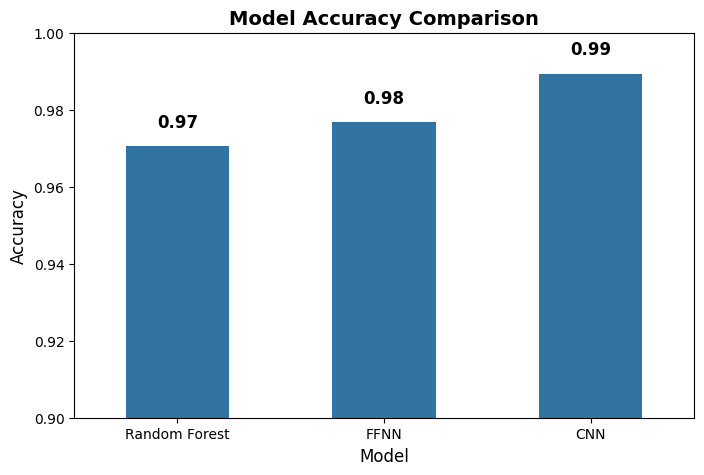

In [21]:
plt.figure(figsize=(8, 5))
sns.barplot(x=[model_names[m] for m in results], y=[results[m]["accuracy"] for m in results], width=0.5)

plt.title("Model Accuracy Comparison", fontsize=14, fontweight='bold')
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.9, 1)

for index, model in enumerate(results.keys()):
    plt.text(index, results[model]["accuracy"] + 0.005, f"{results[model]['accuracy']:.2f}",
             ha='center', fontsize=12, fontweight='bold')

plt.show()



## Real Predictions on Test Images
The trained models will now predict real examples from the MNIST dataset.


1/1 [==============================] - 0s 32ms/step


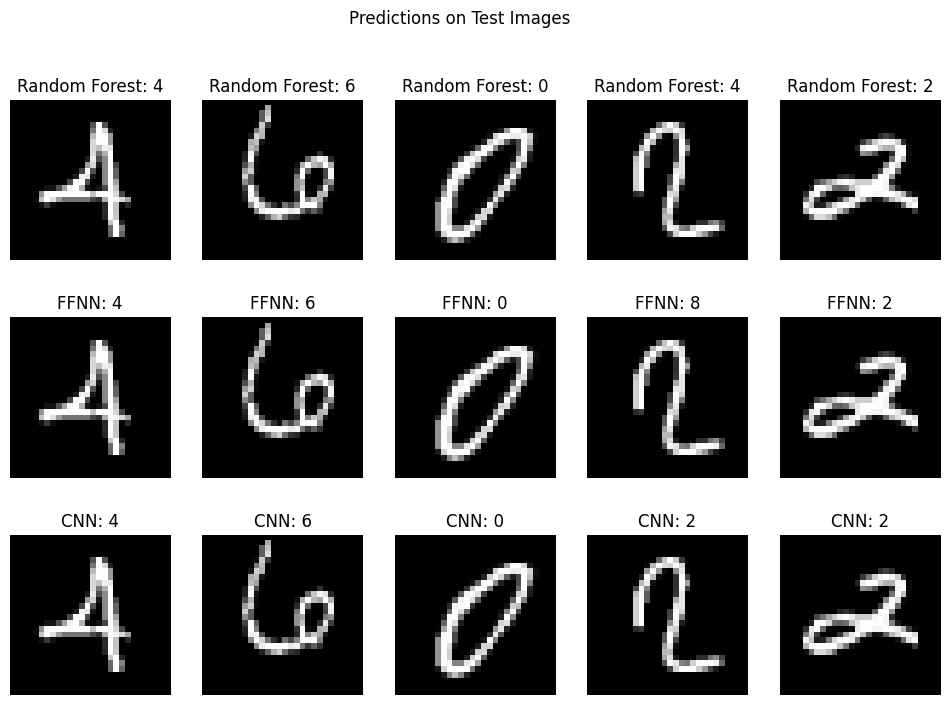

In [18]:
fig, axes = plt.subplots(len(model_types), 5, figsize=(12, 8))
fig.suptitle("Predictions on Test Images")

for i in range(5):
    idx = randint(0, len(X_test) - 1)
    img = X_test[idx]

    for j, model in enumerate(model_types):
        classifier = results[model]["classifier"]

        if model == "rf" or model == "nn":
            img_input = np.expand_dims(img.reshape(-1), axis=0)
        else:
            img_input = np.expand_dims(img, axis=0)

        pred = classifier.predict(img_input)

        axes[j, i].imshow(img, cmap='gray')
        axes[j, i].set_title(f"{model_names[model]}: {pred[0]}")
        axes[j, i].axis("off")

plt.show()


## Edge Cases: Testing Models on Noisy Images
The models will now classify noisy images.


1/1 [==============================] - 0s 36ms/step


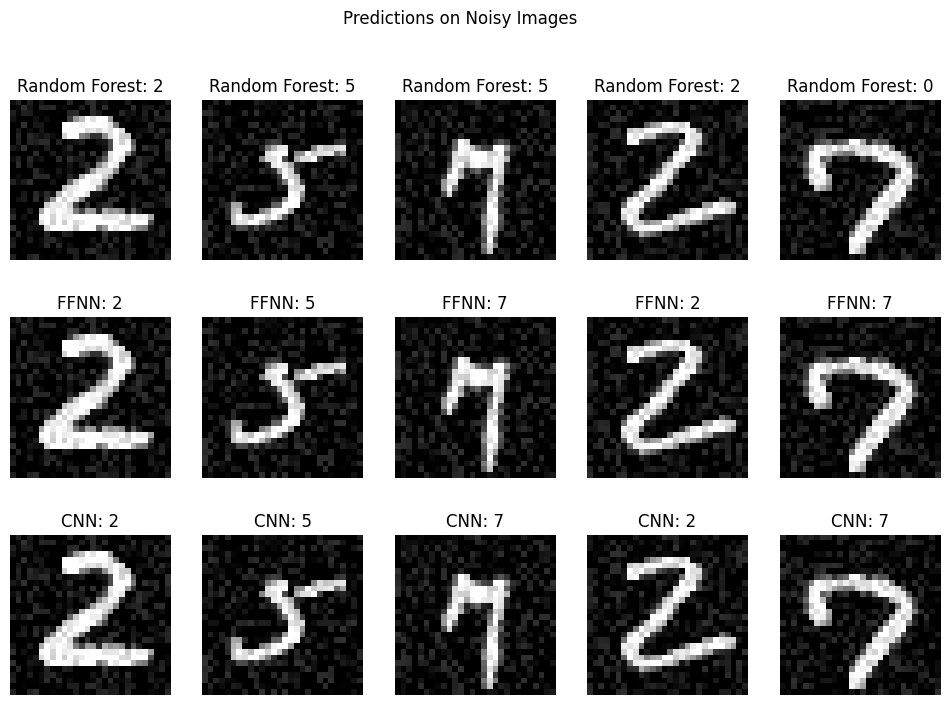

In [20]:
def add_noise(image, noise_level=50):
    noise = np.random.randint(-noise_level, noise_level, image.shape)
    return np.clip(image + noise, 0, 255)

fig, axes = plt.subplots(len(model_types), 5, figsize=(12, 8))
fig.suptitle("Predictions on Noisy Images")

for i in range(5):
    idx = randint(0, len(X_test) - 1)
    noisy_img = add_noise(X_test[idx])

    for j, model in enumerate(model_types):
        classifier = results[model]["classifier"]

        if model == "rf" or model == "nn":
            img_input = np.expand_dims(noisy_img.reshape(-1), axis=0)
        else:
            img_input = np.expand_dims(noisy_img, axis=0)

        pred = classifier.predict(img_input)

        axes[j, i].imshow(noisy_img, cmap='gray')
        axes[j, i].set_title(f"{model_names[model]}: {pred[0]}")
        axes[j, i].axis("off")

plt.show()


## Summary of Model Performance

### Results
- CNN: Best performance, handles both clean and noisy images well.
- FFNN: Decent accuracy but struggles slightly with noise.
- Random Forest: Weakest model, misclassifies noisy and complex digits.

### Key Observations
- CNN extracts features best, making it the most accurate.
- FFNN performs well but is sensitive to distortions.
- Random Forest fails on noise and similar-looking digits (e.g., 4 vs. 9).

### Potential Improvements
- Random Forest → Use PCA, ensemble methods, more estimators.
- FFNN → Add dropout, tune layers, improve data augmentation.
- CNN → Increase depth, optimize learning rate, use better activation functions.
